In [1]:
%load_ext autoreload
%autoreload 2
# This is useful if you want to modify a module, these changes will then be accessible in the notebook.



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The structure of this notebook

- First we will briefly cover the need for and types of component separation methods 
- Next we will investigate what the sky looks like in polarization
- Finally we will develop a simple internal linear combination (ILC) method to make foreground-cleaned maps of the CMB E and B mode polarization in simple simulations



# A quick introduction

So far we have largely considered observations of the sky at a single frequency. Unfortunately for us as CMB scientists the mm-wave sky is composed of many sources, both Galactic and extragalactic in origin, that obscure the CMB anisotropies. (Of course, these contributions are very interesting to study as signals in their own right; however today we will limit our discussion to treating these as contaminants). 


Fortunately these other signals, hereafter termed "foregrounds", have different spectral and spatial properties to the CMB anisotropies. The spectral properties of the key Galactic signals can be seen in Figure (1):
### Figure (1)

<div>
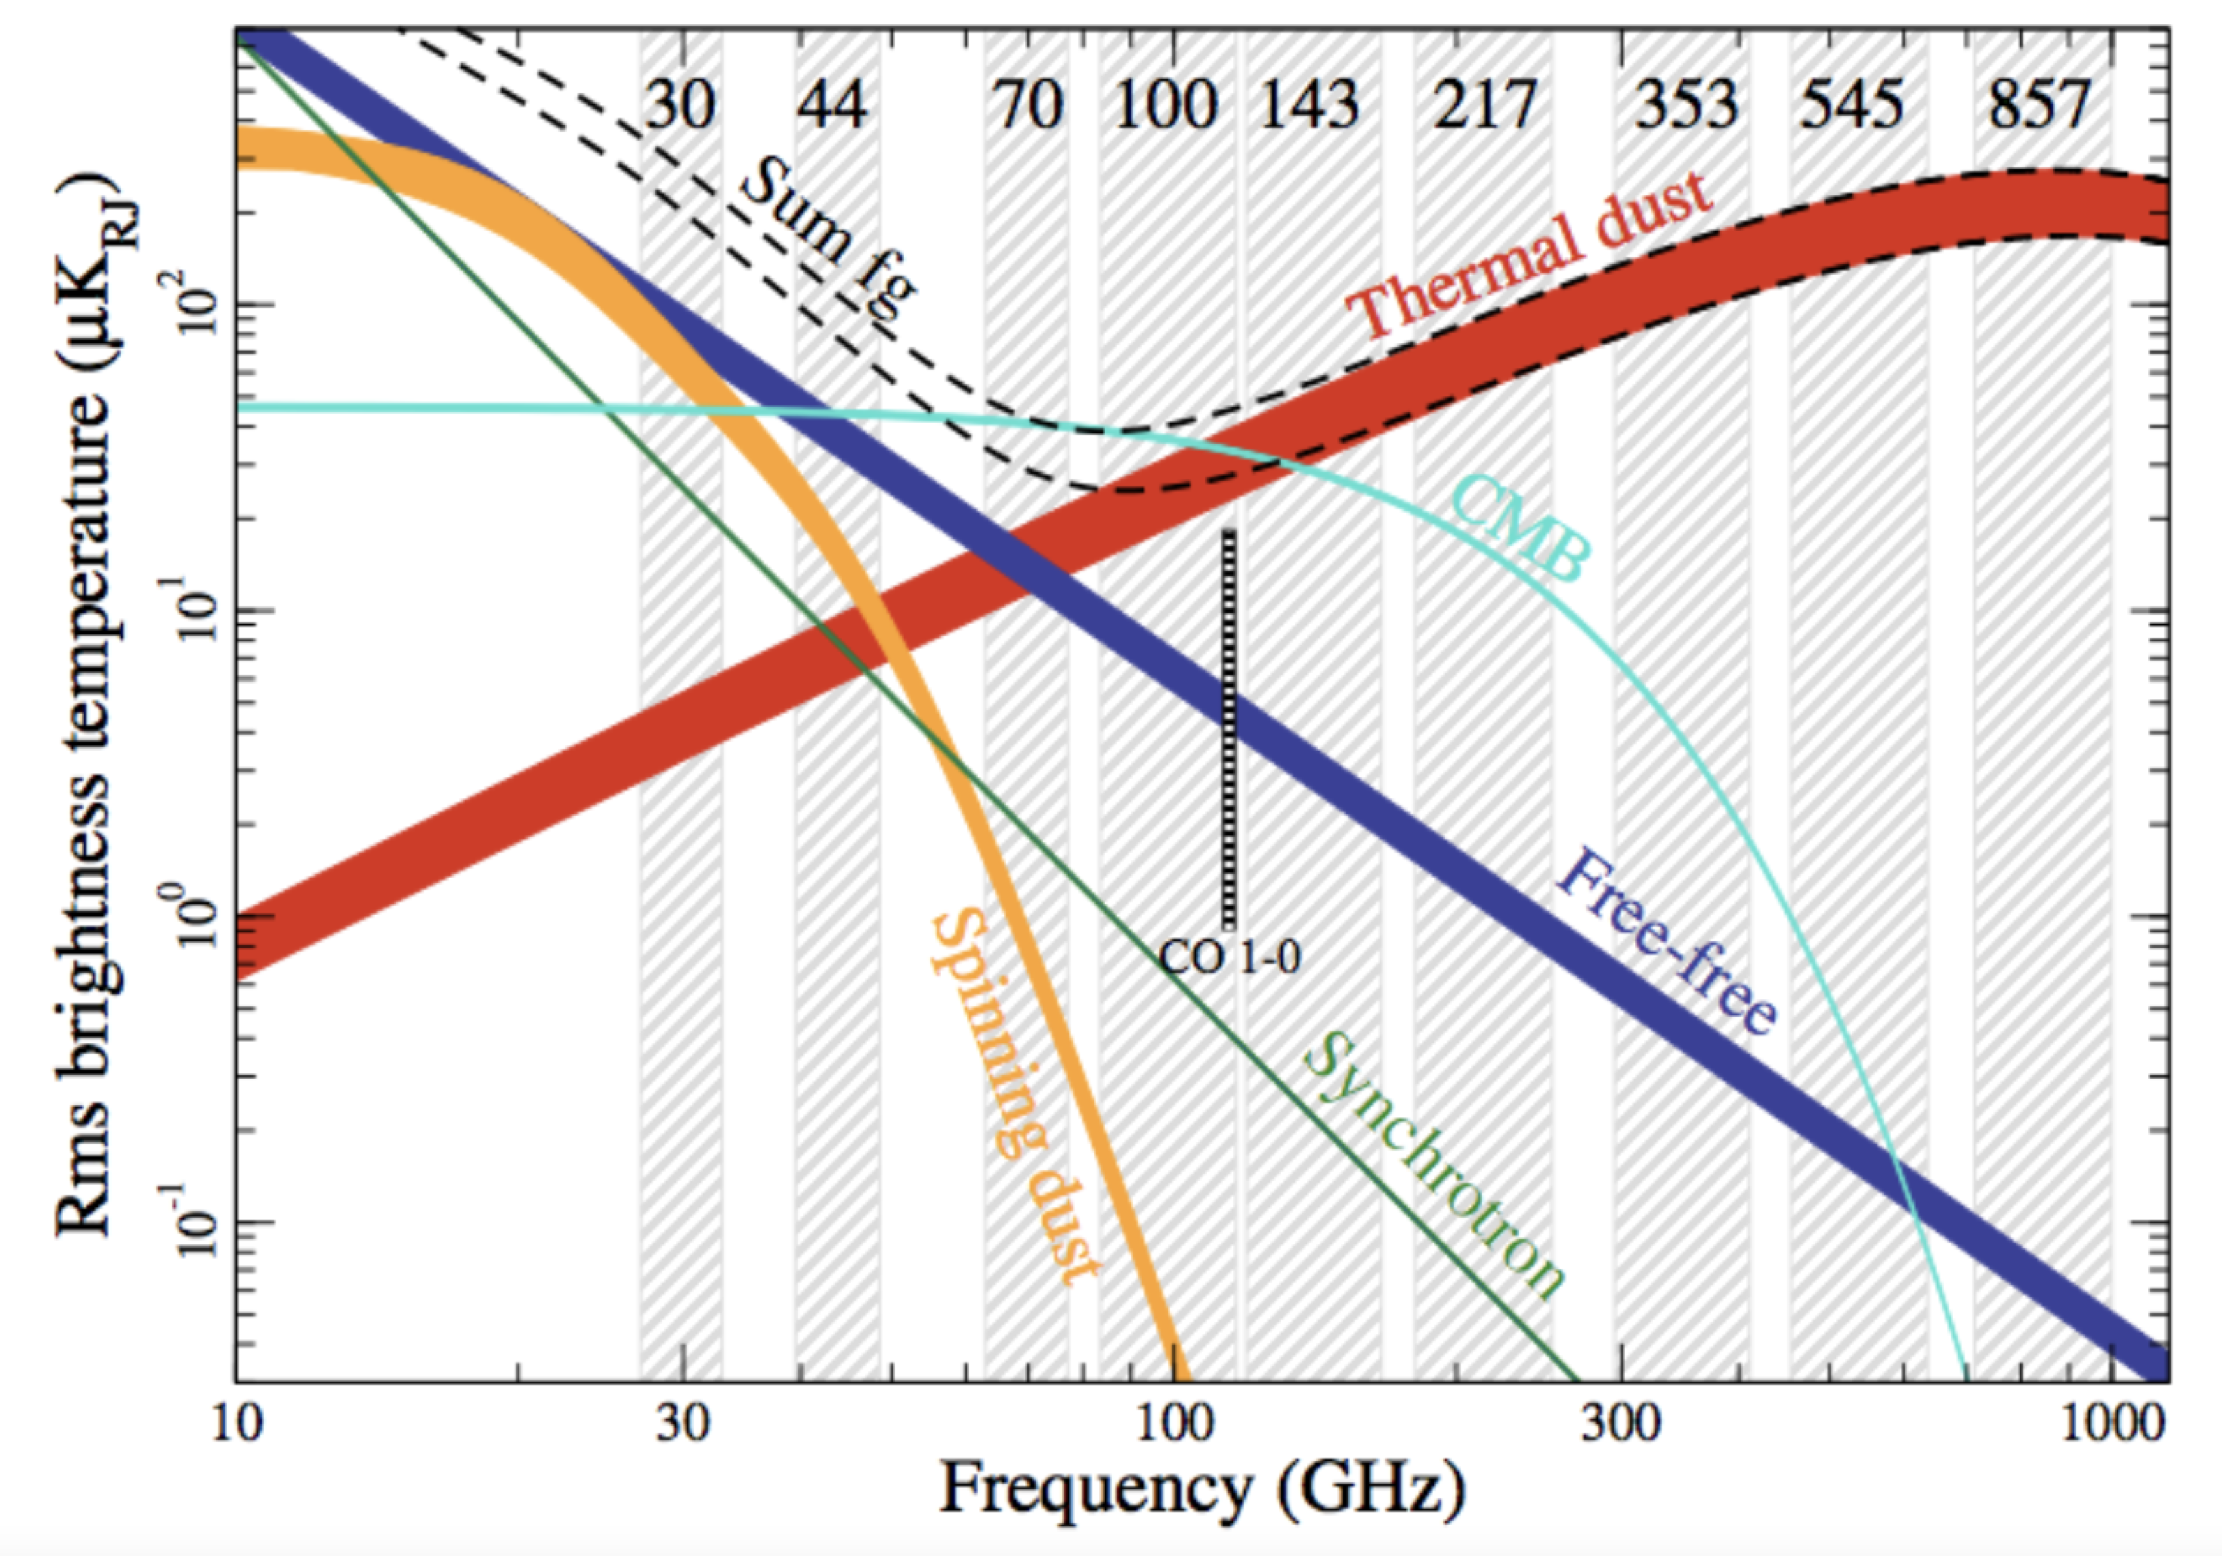
</div>
 Source: Dickinson et al (2016) - which is a nice, quick overview of the Galactic contributions to the mm-wave sky (https://arxiv.org/abs/1606.03606)


The figure shows the average (rms) fluctuation on ~1 degree scales over ~80% of the sky (masking the Galactic plane).

We see that even if we observe the sky around 70 GHz in temperature, where the CMB is the dominant sky signal, the Galactic signals are not negligible (and neither are the extragalactic sources).  Thus for any analysis of CMB  anisotropies we need to understand and/or remove these signals.

Comments:
- perhaps better to show polarization?
- also would be good to include a description of the foreground signals, e.g.:

A fairly complete list of components in the mm-wave sky includes (see, e.g., https://lambda.gsfc.nasa.gov/product/foreground/ ):

- CMB;
- Thermal Sunyaev-Zel'dovich effect: the inverse-Compton scattering of CMB photons off hot electrons, e.g., in galaxy clusters;
- Kinematic Sunyaev-Zel'dovich: similar to above, but due to the relative motion of the electrons (essentially a Doppler boost);
- Cosmic infrared background (CIB): the cumulative thermal dust emission from all galaxies in the universe;
- Radio point sources: radio emission from active galactic nuclei (supermassive black holes);
- Dust from our galaxy: thermal dust emission from grains in the Milky Way;
- Synchrotron emission from our galaxy: emission from relativistic electrons spiraling in the magnetic field of the Milky Way;
- Spinning dust emission: dust emission from small grains that are spinning due to various processes (in the Milky Way);
- Free-free emission: bremsstrahlung emission from electrons scattering off ions in the Milky Way;
- CO emission: line emission from carbon monoxide molecules in the Milky Way (and some nearby galaxies). 






<div>
<img src="attachment:foreground_spectra-3.png" width="500"/>
</div>


Foreground mitigation techniques can be broadly grouped into two classes that we will call non-blind and blind approaches. In non-blind methods, we typically assume a parametric form for the spectral, and potentially spatial, properties of the foregrounds. Given this model and a likelihood (almost always a Gaussian likelihood), we fit for the properties of the foreground model and the CMB. We can then use a maximum-likelihood approach or sampling-based approach (see the likelihood and MCMC notebooks) to recover the CMB. This approach has been extensively used in the CMB community to marginalize over the contributions from Galactic and extragalactic foregrounds at the power spectrum level (i.e., in the most common version of this approach, one does not obtain maps of each foreground component). Thus when you see plots of the CMB temperature power spectra, e.g. Figure 2, you are likely seeing the results of a non-blind/parametric component separation method:

### Figure (2)

<div>
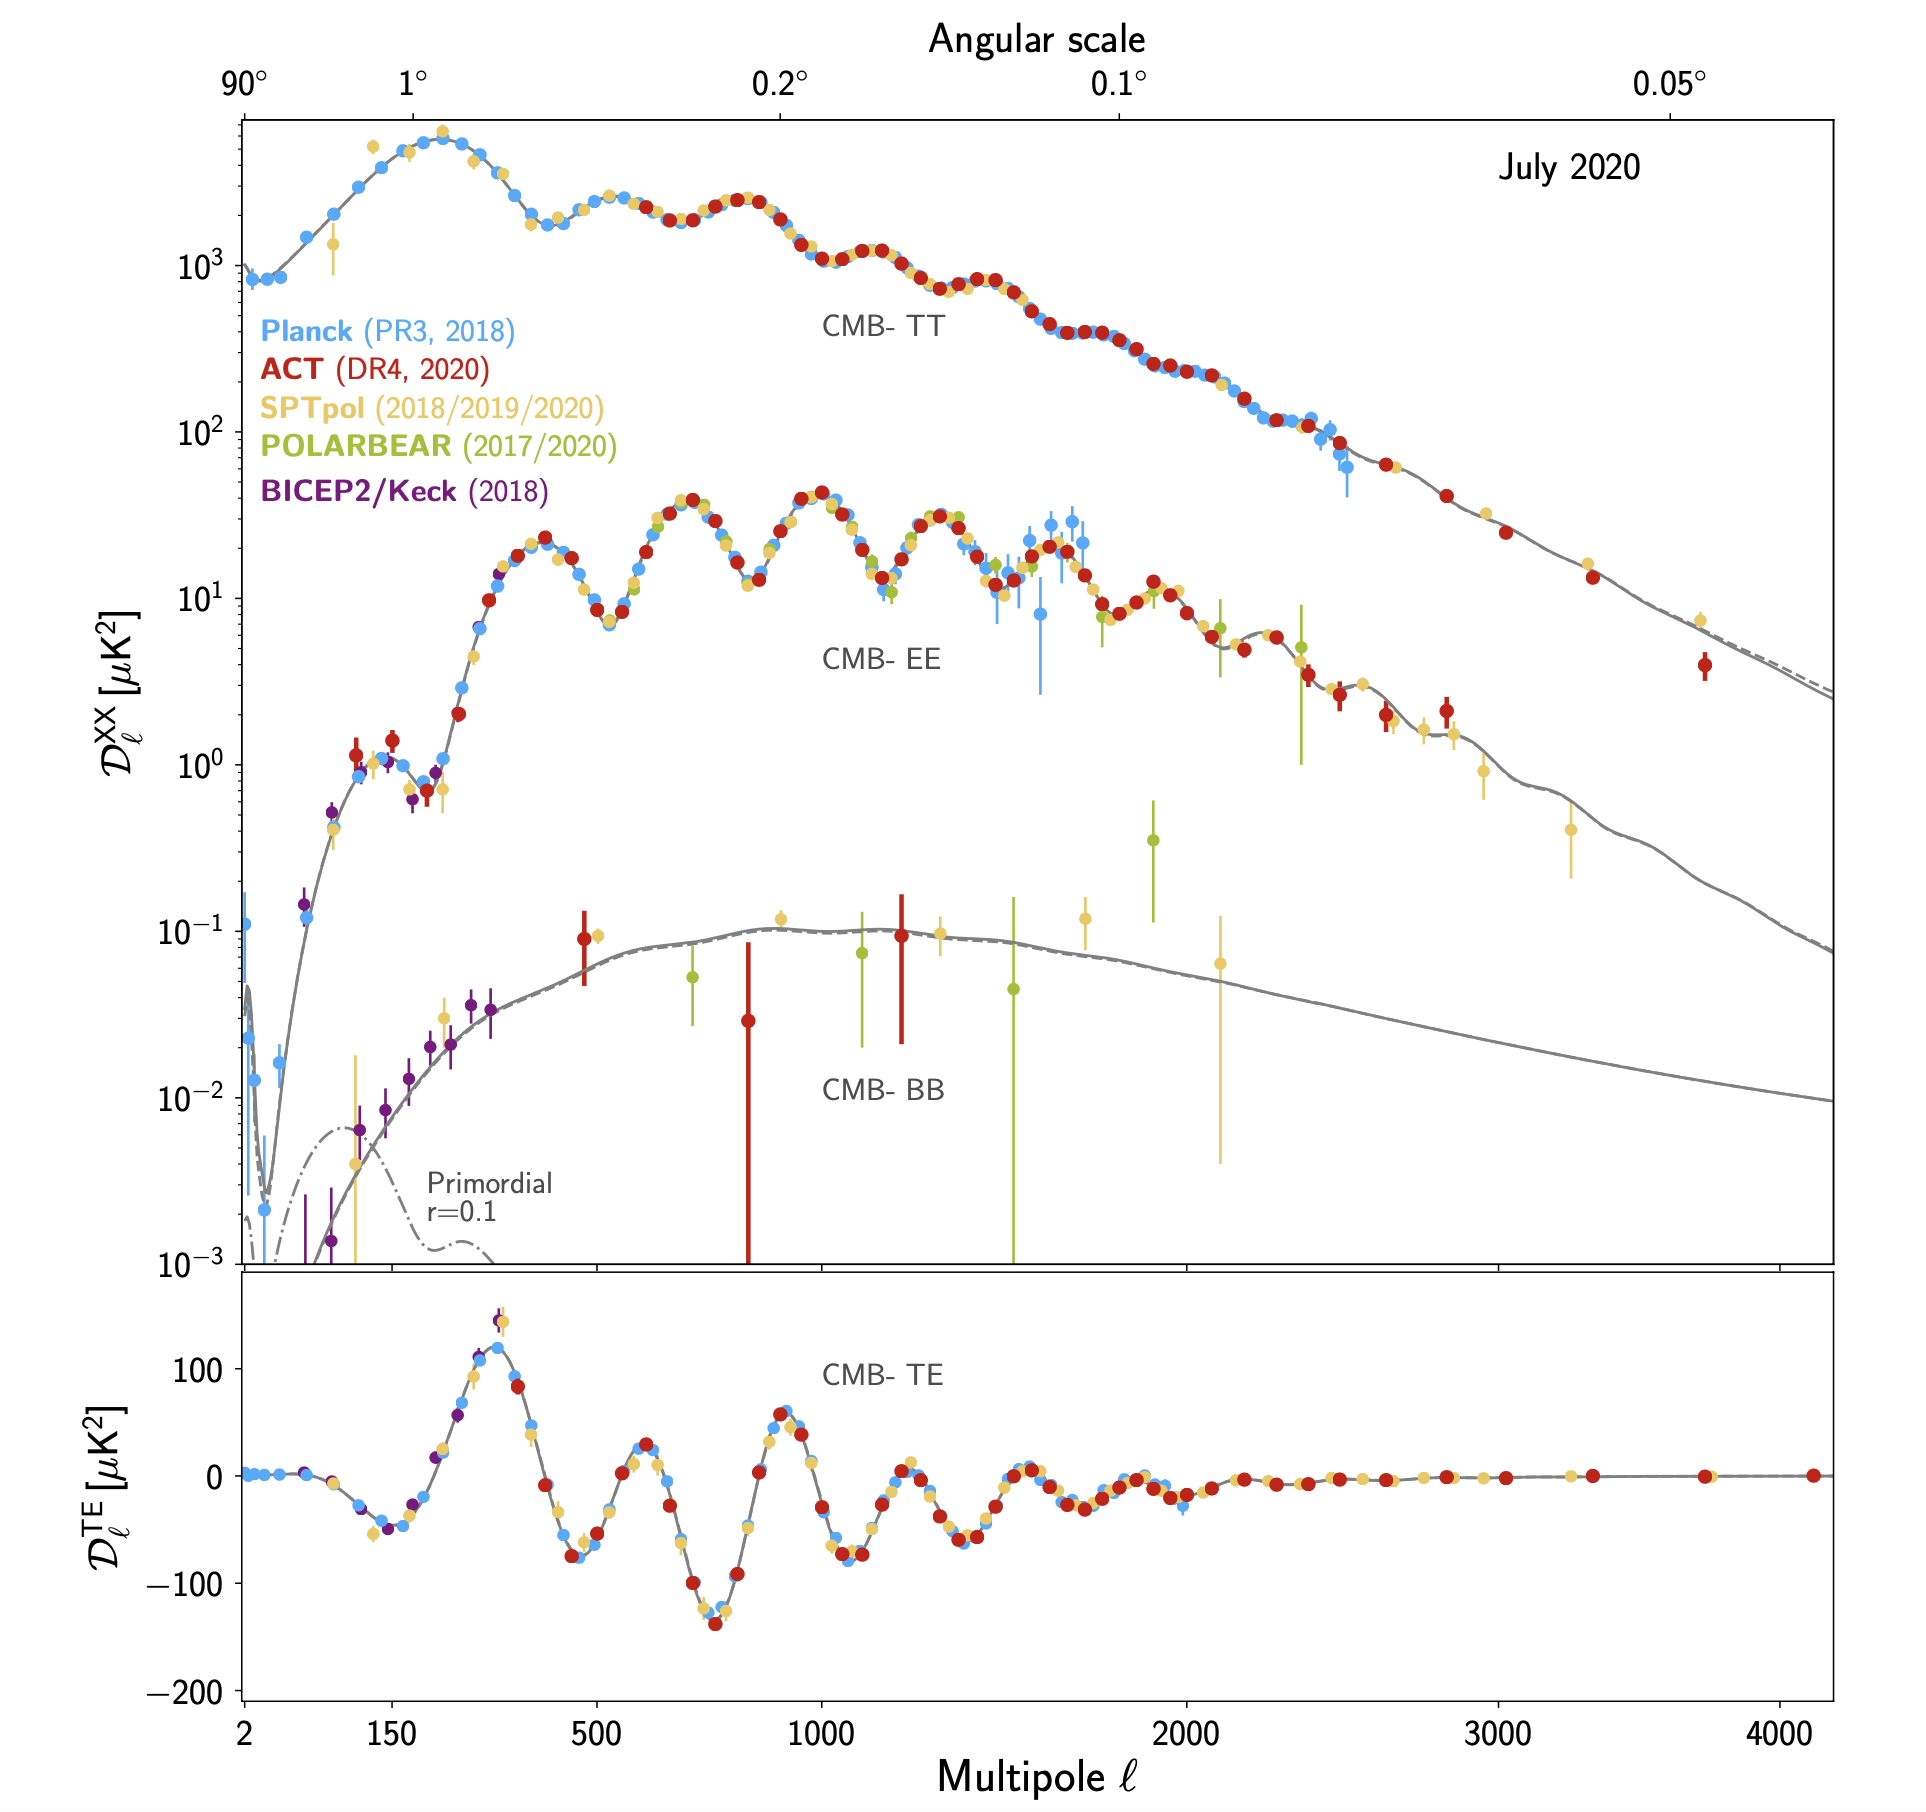
</div>
Source: Choi et al 2020

Blind methods assume that the spectral dependence of the primary signal is known perfectly, which is a very good assumption (the COBE-FIRAS experiment measured the CMB blackbody spectrum to one-part-in-10^5 precision). They then make minimal assumptions about the properties of the foregrounds to obtain the CMB component. In this tutuorial we will explore one of the simplest of such methods: the internal linear combination. It only makes the assumption that the foregrounds are spatially uncorrelated with the CMB anisotropies. This method then linearly combines observations at multiple frequencies to obtain a CMB map that minimize the variance of this component. To obtain this solution the properties of the foregrounds are implicitly estimated from the empirical data. We will discuss the details of this more below. 


As always, each foreground separation method has its advantages and disadvantages and should be chosen to suit the specific problem. 

# What's the sky like in polarization?

In [2]:
# Import some useful modules
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from pixell import enmap,curvedsky,enplot
import foregrounds
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

To start with we will work with some simplified sky simulations. This will allow us to work on the full sky and so use simple power spectrum estimators and not have to worry about the complexities of dealing with masks, etc.

For simplicity we will work with just part of the polarized sky: the E mode component. 
(The E mode map is a spin 0 field so is transformed to and from harmonic space in an identical manner to T maps)

In [4]:
# This is a simple class that we will use to generate observations of the sky
simple_sky_model = foregrounds.simple_sky_model(seed=1,)

# To simulate an observation use the observe method as follows:
E_map      = simple_sky_model.observe(freq_GHz=150,noise_ukarcmin=1.,beam_fwhm_arcmin=8.)

In [5]:

# # For those of you up for more of a challenge we can work with Q/U instead. Use this class:

# simple_sky_model = foregrounds.simple_sky_model_dualComp(seed=1,)

# # The interface should otherwise be identical
# # except where above will return a single map (the E map) this function will return two: the Q &U maps.

# Q_map,U_map      = simple_sky_model.observe(freq_GHz=150,noise_ukarcmin=1.,beam_fwhm_arcmin=8.)

### Task 1)

Observe the sky (do not worry about making a mask, as our simple simulation is isotropic) and create an empirical version of Figure (1) for E and B mode polarization. 

Note the maps are in temperature units, so the scale of the plot will be a tad different. We'll address that below!

I.E. Observed rms E /B mode vs frequency (or if you prefer C(ell=50) and C(ell=300) for EE, BB vs frequency).

In [6]:
### Your code goes here

We know empirically that the polarized sky is slightly simpler than the temperature case. At the frequencies of interest there are just three non-negligible components: dust, synchrotron, and the CMB.

Let's make a quick estimate of the relevance of each of the components. Use the two frequency functions below to  perform a crude by-eye fit to the above plot for the three components. 

The synchrotron spectral energy distribution is modelled as a power law in frequency. 

The dust SED is modelled as a grey body:
$I(\nu) = \nu^\beta B_\nu(T_d)$ where $\beta$ is the dust  spectral index that is observed to be $\sim 1.4$ and T$_d$ is the dust temperature that is $\sim 15$K.

One slight complication. The dust SED are measures of flux and so are in units of Janskys per steradian, whereas we normally think in terms of thermodynamic temperature units for the CMB anisotropies (frequently $\delta T/T$ or $\mu$K or nK). To plot the three components you should standardize the units. (If you need some ideas on how to do this perhaps have a look around eq.5 and eq.6 here: https://arxiv.org/pdf/1303.5087.pdf)

In [7]:
from foregrounds import synchrotron_SED,galaticDust_SED
# Example usage
print(synchrotron_SED(freq_GHz=30))
print(galaticDust_SED(freq_GHz=150))

71.8406572197408
10611518.507824272


In [8]:
### Your code here!

# The Internal Linear Combination method (ILC)

We will apply the ILC method in harmonic space to obtain cleaned maps of E and B modes; however this method can be applied in any basis (e.g., in real space or in principle to Cls themselves) so in our discussion below we use a general notation.

We have a set of observations of the sky, $\hat{d}_{\nu_i}(\mathbf{n})$, at frequency, $\nu_i$, and spatial/harmonic index $\mathbf{n}$.

We are intersted in recovering the signal, $s(\mathbf{n})$ , which contributes to an observation at frequency each frequency by $a_{\nu_i}s(\mathbf{n})$. For this method we assume that we know exactly the spectral function  and so can compute $a_{\nu_i}$. For the CMB we do know this very accurately!! 



Given this signal model we can express our data vector as:

### $\hat{d}_{\nu_i}(\mathbf{n}) = a_{\nu_i}s(\mathbf{n}) + n_{\nu_i}$

where $ n_{\nu_i}$ is called the 'noise' at frequency $\nu_i$. This 'noise' is actually composed of everything that is not the signal of interest! For our case the noise will be composed of the experimental noise, the dust emission and the synchrotron emission.

The idea of the ILC is create a linear combination of these maps to recover the signal:

### $\hat{s}(\mathbf{n}) = \sum\limits_i w_i(\mathbf{n})\hat{d}_{\nu_i}(\mathbf{n})$.

(For clarity we suppress the $\mathbf{n}$ index from here on )


We impose two conditions upon these weights:
- Firstly we want an unbiased measurement of the signal. Thus we impose:

### $\sum\limits_i w_i a_{\nu_i} = 1$.
- Secondly we want the lowest possible noise level, i.e. variance, in the resulting map. I.e.:

### $\frac{\partial}{\partial w_i} \langle \hat{s}(\mathbf{n}) \hat{s}(\mathbf{n}) \rangle =0 $

It is a straightforward exercies to show that the weights that satisfy these conditions are given by 

### $w_i =\frac{{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}}{a_{\nu_i}{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}}$

where ${C^{-1}}^{\nu_i,\nu_j}$ is the inverse of the frequency-frequency covariance matrix (here written in real space as a sum over pixels p):

$C^{\nu_i,\nu_j} =  N_{\rm pix}^{-1} \sum_p \Delta T_{\nu_i}(p ) \Delta T_{\nu_j}(p )$

Thus the solution for the CMB map is 

### $\hat{s}(\mathbf{n}) = \frac{a_{\nu_i}{C^{-1}}^{\nu_i,\nu_j}\hat{d}_{\nu_j} }{a_{\nu_i}{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}} $

A priori we do not always (or even often) know the frequency-frequency covariance matrix. To solve this we use the empirical covariance matrix!




In some cases we want to have a map which explicitly nulls a component on the sky. The ILC method can be extended to do this. See, e.g.: https://arxiv.org/pdf/1911.05717.pdf

Limitations of the ILC method: 
- If you have an accurate parametric form for all of the sky components, then that model may be able to achieve a lower noise CMB reconstruction.
- We assume that the component of interest has a unique spectral signature. If you have a second component with the same frequency response this will also be present in your final map. As a practical example: an ILC map from the primary temperature anisotropies would contain both CMB anisotropies and the kinematic SZ signal, as these have the same (blackbody) frequency dependence.
- As the remaining noise is a combination of instrumental noise and residual foregrounds, it is difficult to construct splits of the data with independent noise. Thus power spectra of the maps will always have a foreground "noise bias" term that needs to be computed (often via simulations). 
- Caution needs to be taken if part of the 'noise' is correlated with the signal of interest.

# Let's try it out!

Let's generate a set of idealized observations

In [9]:
maps = {}
for freq in [27,39,98,150,225]:
    E_map      = simple_sky_model.observe(freq_GHz=freq,noise_ukarcmin=3.,beam_fwhm_arcmin=freq/150.*20.)
    maps[freq] = E_map

## Step 1)
Measure the E and B a_lm (harmonic coefficients) and the auto and cross spectra

In [10]:
### Your code here

# For convienient later perhaps wrap it all in a function alms,cls = fnc(maps)

# Step 2)

Construct the ILC! Compute at each $\ell$:
### $w_i =\frac{{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}}{a_{\nu_i}{C^{-1}}^{\nu_i,\nu_j} a_{\nu_j}}$

We are in harmonic space, so $C^{\nu_i,\nu_j}$ here is simply the power spectrum of maps at frequencies $\nu_i,\nu_j$.

Compute the weights separately for the E/B modes.
(Typically np.linalg.solve gives more stable inv. C applications than directly computing the covariance matrix.)

Use curvedsky.almxfl to apply the weights to the alms.

In [11]:
### Your code here


# For convienient later perhaps wrap it all in a function weights = fnc(Cls)

# Step 3)

Compare to the ground truth, first by comparing your ILC map to the input CMB maps and then by comparing their power spectra (for the later it is useful to use both the auto and cross spectrum).

Comment on any similarities / differences!

In [12]:

# alm_cmb_EE,alm_cmb_BB= simple_sky_model.get_input_cmb_alms()

### Your code here

# Step 4)

Compute the cross power spectrum of the ILC map with the input dust and sync maps (use the two functions below for retrieving those!). Is this consistent with zero?



Bonus exercise: given these true components what is a trival way to get a clean CMB map? What assumptions underlie this approach?

In [13]:

# alm_cmb_EE,alm_cmb_BB= simple_sky_model.get_input_cmb_alms()

# alm_cmb_EE,alm_cmb_BB= simple_sky_model.get_input_cmb_alms()

# Step 5)

Put your code in a loop. Generate a set of new maps (change the seed for the sky each time) and a new set of ILC maps. Compute the average cross-power spectrum of your ILC maps with the input (ground truth) CMB map.  Does your method give an unbiased measurement of the sky?

In [14]:

### Your code here

# Optional extension 1)
Did you find a bias? This is known as the ILC bias! 


This bias occurs due to our use of the empirical covariance matrix in the weights. This can be understood simply: the weights depend on the data.  Thus imagine that we have a large upward fluctuation in the data -- this will result in a large fluctation in the covariance and will result in that mode being excessively downweighted in the ILC solution (the covariance matrix depends on the data squared). Phrased more broadly the covariance matrix has a correlation with the data and so when we compute the expected value for the ILC solution we need to include these.


For a comprehensive discussion of this see the appendices of https://arxiv.org/pdf/0807.0773.pdf

#### How can we avoid this?  
- The true covariance matrix! Unfortunately this is not generally available.
- Compute the covariance matrix from an independent set of modes.
- In our case we can make the approximatation the covariance of adjacent $\ell$ is same. Thus we can compute the covariance matrix at each ell using the spectra at $\ell+1$ and  $\ell-1$. 
- This approach can be difficult to implement in practice where different ells are correlated (e.g. do to masking) and as it rapidly becomes computationally very expensive.

#### How can we supress this? 
- We can use reduce these biases by averaging modes. 
- For our case we can do this simply. Instead of using the measured power spectrum at each ell $C_\ell$, we can average over a range of ells. This will reduced the correlation between the covariance matrix and the data.

## Try one of the above approaches. Does it suppress the bias?

# Optional extension 2)

The model of the galaxy used here is overly simplistic! 

Let's repeat this exercise with a more accurate model. We can use the excellent pysm library for this purpose. 

The installation instructions for this library are available here: https://pysm3.readthedocs.io/en/latest/#installation

However, one of these commands should work for you too:

pip install pysm3

conda install -c conda-forge pysm3


The library can be straightforwardly used with a few lines of code:




In [26]:
# Import the library and the units module for convienience:
import pysm3;
import pysm3.units as u

With the library imported we initalized the sky class.
- nside sets the resolution of the maps, 
- preset_strings defines the models used for the sky. In this case we the models 'd1' for dust 1 and "s1" for synchroton model one. More information on the available models can be found on : https://pysm3.readthedocs.io/en/latest/  . The more accurate models allow us to test how well our foreground cleaning methods work when, for example, the dust spectral index varries across the map.


Note when using this for the first time it will require an internet connection as it will download a set of template maps. This will generate a set of warnings.

In [27]:
# Initalize the sky object

sky = pysm3.Sky(nside=512,preset_strings=["d1","s1"],output_unit="K_CMB")
# Get the map at the desired frequency:
I,Q,U = sky.get_emission(150*u.GHz)

/Users/wcoulton/opt/anaconda3/envs/dataSchool/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/wcoulton/opt/anaconda3/envs/dataSchool/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/wcoulton/opt/anaconda3/envs/dataSchool/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/wcoulton/opt/anaconda3/envs/dataSchool/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_beta.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/User

/Users/wcoulton/opt/anaconda3/envs/dataSchool/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/wcoulton/opt/anaconda3/envs/dataSchool/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/wcoulton/opt/anaconda3/envs/dataSchool/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning

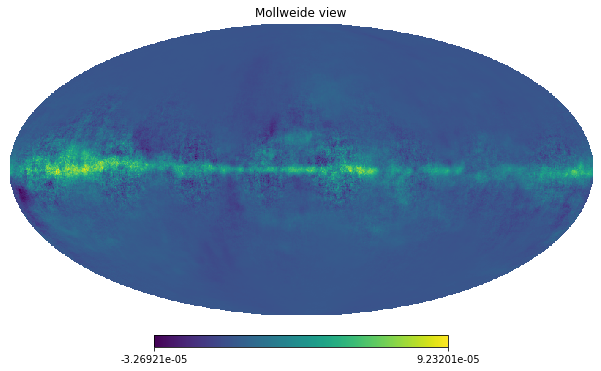

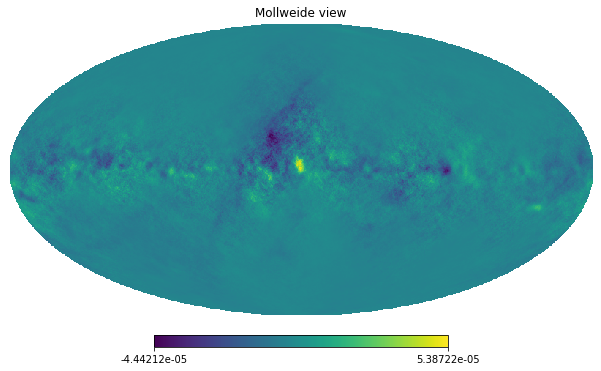

In [28]:
hp.mollview(Q)
hp.mollview(U)

For ease we have included a simple wrapper of this in a format identical to our simple model

In [31]:
pysm_sky_model = foregrounds.pysm_sky_model(seed=1)
pysm_sky_model.observe(freq_GHz=150,noise_ukarcmin=1.,beam_fwhm_arcmin=8.)

/Users/wcoulton/opt/anaconda3/envs/dataSchool/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/wcoulton/opt/anaconda3/envs/dataSchool/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/wcoulton/opt/anaconda3/envs/dataSchool/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/wcoulton/opt/anaconda3/envs/dataSchool/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_beta.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/User

Preparing SHT
T -> alm
float64 complex128
P -> alm
Projecting


(ndmap([[-0.55388723 -0.55334111 -0.55279429 ... -0.55552129 -0.55497732
   -0.55443263]
  [-0.02321819 -0.02309197 -0.02296704 ... -0.02360458 -0.02347449
   -0.02334569]
  [ 0.46643384  0.4660265   0.465616   ...  0.46763679  0.46723898
    0.466838  ]
  ...
  [ 3.23239189  3.23136649  3.23033675 ...  3.23544189  3.23442959
    3.23341292]
  [ 3.00492076  3.00487649  3.00482803 ...  3.00502831  3.00499667
    3.00496081]
  [ 2.66645751  2.66734833  2.6682354  ...  2.6637626   2.66466465
    2.66556295]],car:{cdelt:[-0.03333,0.03333],crval:[0.01667,0],crpix:[5400,2701]}),
 ndmap([[ 0.41786867  0.41847931  0.41908932 ...  0.41603293  0.41664548
    0.41725739]
  [ 0.09600901  0.09553056  0.0950521  ...  0.09744438  0.09696593
    0.09648747]
  [-0.27971903 -0.28121742 -0.2827149  ... -0.27521857 -0.27671961
   -0.27821976]
  ...
  [ 0.71015112  0.71386962  0.71758617 ...  0.698984    0.7027083
    0.70643068]
  [-0.05433067 -0.05076599 -0.04720169 ... -0.06502699 -0.06146118
   -0.0578

## Apply the ILC to these more realistic maps

Can you obtain lower noise E/B maps through masking? 

You can download the Planck Galaxy masks with this link:

http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits


We can read the sky mask using the following command:
### mask_healpy =  hp.read_map(fileNameHere,field=index)

index is used to select the desired sky fraction as follows:

0: 20%, 1: 40%, 2: 60%, 3: 70%, 4: 80%, 5: 90%, 6: 97%, 7: 99%

The maps then need to reprojected (see ACT notebook 3!)

### mask = reproject.enmap_from_healpix(mask_healpy, pysm_sky_model.shape, pysm_sky_model.wcs, ncomp=1, unit=1, lmax=pysm_sky_model.lmax_sim,rot=None)


# Optional extension 3)



As discussed above the ILC method can be altered to 'deproject' sky components such that the ILC map not only minimizes the variance on the desired signal but also has zero contribution from a specific component. This is useful if, for example, you want to be sure your CMB map has not contribution from the SZ effect. The cost of this is an increase in the variance in the ILC map.
 
 
This method requires that we accurately know the signal of interests frequency function. Unfortunately this means that it can be used only to reduce residual dust and CIB contributions - not completely remove them! 

## Step 1)

First we need to modify the ILC equation. Recall that to derive the ILC equation we sought a solution that has unit response to the desired signal with minimum variance. To obtain the weights we minize the variance in the presences of a Lagrange multiplier to ensure unit reponse. Now we can simply add an additional constraint. 

First deduce the constraint and then recompute the ILC weights. 

You should find that your solution agrees with eq. 18 in https://arxiv.org/pdf/1006.5599.pdf

# Step 2)

Rerun your code from above using the modified weights. Deproject the dust contribution using the spectral functions from the first section.